# From biological to Artificial neuron

## The Perceptron

In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target == 0  # Iris Setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

Perceptron(random_state=42)

In [4]:
per_clf.predict([[2, 0.5], [3, 1]])

array([ True, False])

The Perceptron is equivalent to an SGDClassifier, implemented as following code cell.

In [5]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(
    loss="perceptron", penalty=None, learning_rate="constant", eta0=1, random_state=42
)
sgd_clf.fit(X, y)
assert (sgd_clf.intercept_ == per_clf.intercept_).all()
assert (sgd_clf.coef_ == per_clf.coef_).all()

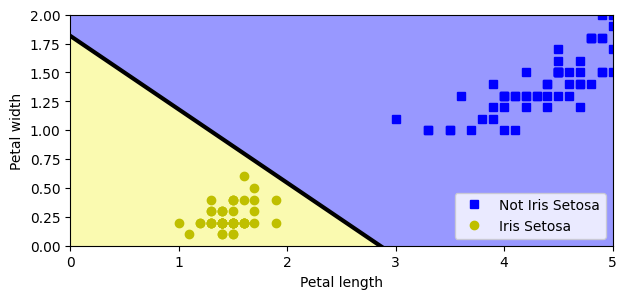

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]

axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(["#9898ff", "#fafab0"])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris Setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris Setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.legend(loc="lower right")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([0, 5, 0, 2])
plt.show()

**Activation function**

Here we plot some popular activation functions and their derivatives.

In [7]:
from scipy.special import expit as sigmoid


def relu(z):
    return np.maximum(z, 0)


def derivate(f, z, epsilon=1e-6):
    return (f(z + epsilon) - f(z)) / epsilon


max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

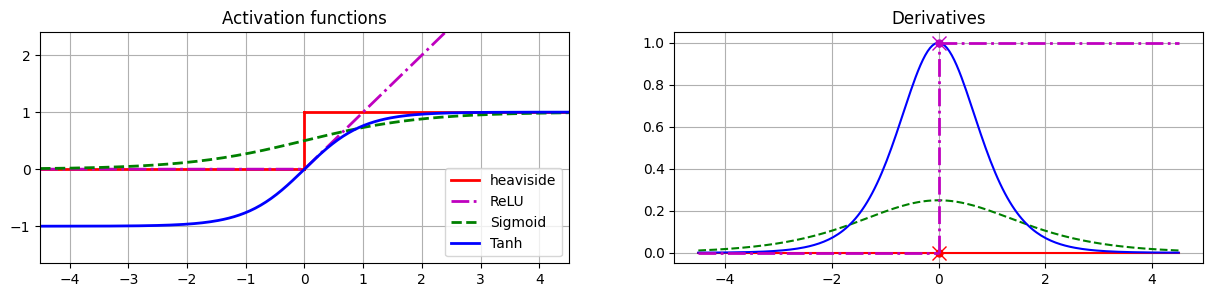

In [8]:
plt.figure(figsize=(15, 3))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="heaviside")
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot([0, 0], [0, 1], "r-", linewidth=2)
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.grid()
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.title("Activation functions")
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(z, derivate(sigmoid, z), "g--")
plt.plot(z, derivate(np.sign, z), "r-")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivate(np.tanh, z), "b-")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2, label="heaviside")
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid()
plt.title("Derivatives")

plt.show()

## Regression MLPs

We can train MLP using MLPRegressor in scikit-learn. <br>

Its parameters is very similar to Linear Regression, so here I will just explain the unique parameters of MLPRegressor:
- hidden_layer_sizes: A list contains the number of neuron in each hidden layer.
- activation: Activation functions used in the neural network
- solver: the weight optimization algorithm, default is Adam
- alpha: the hyperparameter for regularization, default is a bit of regularization.

In [9]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42
)

mlp_reg = MLPRegressor([50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_predict = pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, y_predict, squared=False)

In [10]:
rmse

0.5053326657968756

The error is about 0.505, comparable with a Random Forest, which is not bad for our first try!

## Classification MLPs